#Get the notebook ready
importing all the libraries and getting test data into dataloader

In [1]:
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision
from torchvision import models
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
from torchvision import transforms as T
from torchvision.ops import nms

import json
from collections import defaultdict
import pandas as pd
import numpy as np


import os
from scipy.interpolate import interp1d
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from roboflow import Roboflow
import random
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
CLASS_COLORS = {
    "1": 'r',
    "2": 'w',
}
CLASS_NAMES ={
    "1": "Car",
    "2": "Plate"
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

rf = Roboflow(api_key="IYwf0SjALphOAs60cx0U")
project = rf.workspace("myworkspace-zkmzj").project("license-plate-detector-no-brand")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Detector---no-brand-1 in coco:: 100%|██████████| 2126/2126 [00:01<00:00, 1768.18it/s]


In [5]:
def extract_file_paths(dir):
  json_file = ''
  for f in os.listdir(dir):
    if f.endswith('.json'):
      json_file = dir+f
  return json_file
def extract_image_paths(dir):
  image_files = []
  for f in os.listdir(dir):
    if f.endswith('.jpg'):
      image_files.append(dir+f)

  return image_files
# Opens annotation file
def extract_annotations(label_file):
  f= open(label_file)
  anns =json.load(f)
  return anns

def create_dfs(dir, anns):
  img_df = pd.DataFrame(anns['images'])
  img_df.drop(['height', 'width', 'date_captured', 'license'],axis=1, inplace=True)
  img_df['file_name'] = dir+img_df['file_name']

  ann_df = pd.DataFrame(anns['annotations'])
  ann_df.drop(['segmentation', 'iscrowd', 'area'], axis=1, inplace=True)
  # Extracting bbox values and creating new columns
  ann_df[['x1', 'y1', 'w', 'h']] = pd.DataFrame(ann_df['bbox'].tolist(), index=ann_df.index)
  ann_df['x2'] = ann_df['x1'] + ann_df['w']
  ann_df['y2'] = ann_df['y1'] + ann_df['h']

  ann_df.drop(['w', 'h', 'bbox'], axis=1, inplace=True)

  return img_df, ann_df





In [6]:
test_folder = "License-Plate-Detector---no-brand-1/test/"
test_label_file = extract_file_paths(test_folder)
test_image_files = extract_image_paths(test_folder)
test_anns = extract_annotations(test_label_file)
test_img_df, test_ann_df = create_dfs(test_folder,test_anns)

train_folder = "License-Plate-Detector---no-brand-1/train/"
train_label_file = extract_file_paths(train_folder)
train_image_files = extract_image_paths(train_folder)
train_anns = extract_annotations(train_label_file)
train_img_df, train_ann_df = create_dfs(train_folder,train_anns)


val_folder = "License-Plate-Detector---no-brand-1/valid/"
val_label_file = extract_file_paths(val_folder)
val_image_files = extract_image_paths(val_folder)
val_anns = extract_annotations(val_label_file)
val_img_df, val_ann_df = create_dfs(val_folder,val_anns)

In [7]:
val_img_df.head()

,id,file_name
0,0,License-Plate-Detector---no-brand-1/valid/IMG_...
1,1,License-Plate-Detector---no-brand-1/valid/IMG_...
2,2,License-Plate-Detector---no-brand-1/valid/IMG_...
3,3,License-Plate-Detector---no-brand-1/valid/IMG_...
4,4,License-Plate-Detector---no-brand-1/valid/IMG_...


In [8]:
test_ann_df.head()

,id,image_id,category_id,x1,y1,x2,y2
0,0,0,2,183,279,342.5,411.5
1,1,0,1,0,8,118.0,206.5
2,2,0,1,0,0,640.0,640.0
3,3,1,2,403,390,560.0,456.5
4,4,1,1,150,0,640.0,624.0


In [9]:
test_img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         64 non-null     int64 
 1   file_name  64 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


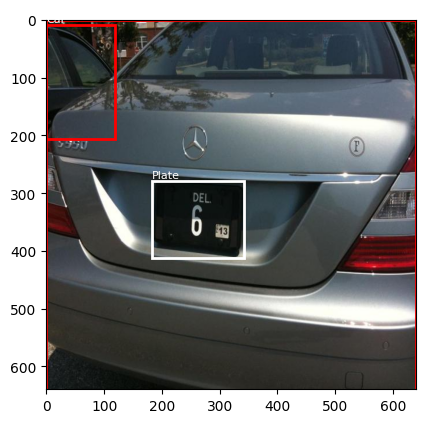

In [10]:
# Function to plot image with bounding boxes
def plot_image_with_annotations(image_id, img_df, ann_df):
    # Get the file path of the image
    image_path = img_df.loc[img_df['id'] == image_id, 'file_name'].values[0]

    # Load the image
    image = Image.open(image_path)

    # Extract annotations for the given image_id
    annots = ann_df[ann_df['image_id'] == image_id]
    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes
    for _, row in annots.iterrows():
        rect = patches.Rectangle((row['x1'], row['y1']), row['x2'] - row['x1'], row['y2'] - row['y1'], linewidth=2, edgecolor=CLASS_COLORS[str(int(row['category_id']))], facecolor='none')

        ax.add_patch(rect)
        class_name = CLASS_NAMES[str(int(row['category_id']))]
        ax.text(row['x1'], row['y1'] - 5, class_name, color='white', fontsize=8)


    plt.show()

# Plot the image with id=0
plot_image_with_annotations(0, test_img_df, test_ann_df)

In [11]:
weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
num_classes = 3
ssd_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(num_classes=num_classes)
preprocess = weights.transforms()

# weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
# num_classes = 3
# custom_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(num_classes=num_classes, weights_backbone='DEFAULT')
# preprocess = weights.transforms()
# Load the saved model weights
ssd_model.load_state_dict(torch.load('/content/gdrive/My Drive/MSc Project/Saved Models/ssd.pth', map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 49.7MB/s]


<All keys matched successfully>

In [12]:
class CustomDataset(Dataset):
    def __init__(self, image_df, annotations_df, transforms=None):
        self.image_df = image_df
        self.annotations_df = annotations_df
        self.transforms = transforms

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        # Get image path and load image
        image_id = self.image_df.iloc[idx]['id']
        img_path = self.image_df.iloc[idx]['file_name']
        image = Image.open(img_path).convert("RGB")

        # Get annotations for the image
        annots = self.annotations_df[self.annotations_df['image_id'] == image_id]
        boxes = annots[['x1', 'y1', 'x2', 'y2']].values
        labels = annots['category_id'].values

        # Convert to PyTorch tensors


        if self.transforms is not None:
          image = self.transforms(image)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return image, target

def collate_function(data):
  return data


In [13]:
test_img_df.shape

(64, 2)

In [14]:
test_set = CustomDataset(test_img_df, test_ann_df,preprocess)
test_loader = DataLoader(test_set,
                        batch_size=16,
                        shuffle = True,
                        drop_last=True,
                        collate_fn=collate_function)

val_set = CustomDataset(val_img_df, val_ann_df,preprocess)
val_loader = DataLoader(val_set,
                        batch_size=16,
                        shuffle = True,
                        drop_last=True,
                        collate_fn=collate_function)

In [15]:
def test_inference(model):
  model.to(device)
  model.eval()
  with torch.no_grad():
    imgs = []
    targets = []
    for data in val_loader:
      for d in data:
        imgs.append(d[0].to(device))
        targ = {}
        targ['boxes'] = d[1]['boxes'].to(device)
        targ['labels'] = d[1]['labels'].to(device)
        targets.append(targ)
    start_time = time.time()
    test_dict = model(imgs)
    end_time = time.time()
  return test_dict, imgs, targets

In [16]:
def time_test(model):
  inferencing_times = []
  model.to(device)
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      for d in data:
        imgs = []
        imgs.append(d[0].to(device))
        start_time = time.time()
        test_dict = model(imgs)
        end_time = time.time()
        inferencing_times.append(end_time - start_time)
  return inferencing_times

In [17]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
# from tqdm import tqdm


# Variables to store true labels and predictions
# all_labels = []
# all_scores = []
outputs, imgs, targets = test_inference(ssd_model)
inferencing_times = time_test(ssd_model)

In [18]:
len(inferencing_times), np.mean(inferencing_times), np.max(inferencing_times), np.min(inferencing_times)

(64, 0.017039421945810318, 0.1366274356842041, 0.013186454772949219)

In [19]:
len(imgs)

128

In [20]:
def reduce_prediction(boxes, scores,classes, conf_threshold = 0.5):
  mask = scores >= conf_threshold
  boxes, scores, classes = boxes[mask], scores[mask], classes[mask]
  keeps = torchvision.ops.nms(boxes, scores, 0.5)

  # nms_boxes = nms(boxes, scores, 0.1) #returns a list of indexes of the good predictions
  return boxes[keeps].cpu(), scores[keeps].cpu(), classes[keeps].cpu()

In [21]:
def build_df(iou_threshold=0.5):
  total_cars= 0
  total_plates = 0

  col_names = ['Image', 'Confidence', 'TP', 'FP', 'FN']
  car_df = pd.DataFrame(columns=col_names)
  plate_df = pd.DataFrame(columns=col_names)
  for i, pred in enumerate(outputs):
    boxes, scores, classes = reduce_prediction(pred['boxes'], pred['scores'], pred['labels'], iou_threshold)
    true_boxes, true_classes = targets[i]['boxes'].cpu(), targets[i]['labels'].cpu()
    total_cars += (true_classes == 1).sum().item()
    total_plates += (true_classes == 2).sum().item()
    detected_cars = (classes == 1).sum().item()
    detected_plates = (classes == 2).sum().item()

    car_FN = abs(torch.sum(true_classes == 1).item() - detected_cars)
    plate_FN = abs(torch.sum(true_classes == 2).item() - detected_plates)

    for box,score,cls in zip(boxes, scores, classes):
      iou = torchvision.ops.box_iou(box.reshape(1,4), true_boxes)
      matching_comp = torch.argmax(iou)
      if iou[0][matching_comp.item()].item() > iou_threshold:
        data_row = [f"Image {i}",score.item(), 1, 0]
      else:
        data_row = [f"Image {i}",score.item(), 0, 1]
      if true_classes[matching_comp.item()] == 1:
        data_row.append(car_FN)
        car_df.loc[len(car_df.index)] = data_row
        car_FN = 0
      elif true_classes[matching_comp.item()] == 2:
        data_row.append(plate_FN)
        plate_df.loc[len(plate_df.index)] = data_row
        plate_FN = 0
  return car_df, plate_df, total_cars, total_plates

# def build_df(iou_threshold=0.5):
#     col_names = ['Image', 'Confidence', 'TP', 'FP', 'FN']
#     car_df = pd.DataFrame(columns=col_names)
#     plate_df = pd.DataFrame(columns=col_names)
#     plate = 0
#     for i, pred in enumerate(outputs):
#       boxes, scores, classes = reduce_prediction(pred['boxes'], pred['scores'], pred['labels'], iou_threshold)
#       true_boxes, true_classes = targets[i]['boxes'].cpu(), targets[i]['labels'].cpu()
#       detected_cars = (classes == 1).sum().item()
#       detected_plates = (classes == 2).sum().item()
#       true_cars = (true_classes == 1).sum().item()
#       true_plates = (true_classes ==2).sum().item()
#       car_fn = true_cars - detected_cars
#       plate_fn = true_plates - detected_plates
#       # Initialize tracking sets
#       matched_true_boxes = set()
#       image_tp = {'car': 0, 'plate': 0}
#       image_fp = {'car': 0, 'plate': 0}
#       image_fn = {'car': 0, 'plate': 0}
#       for box, score, cls in zip(boxes, scores, classes):
#         iou = torchvision.ops.box_iou(box.reshape(1, 4), true_boxes)
#         if iou.numel() > 0:
#           matching_comp = torch.argmax(iou) #finds highest over lap between pred and truth - this gives the most likley match up
#           if iou[0][matching_comp.item()].item() > iou_threshold:
#             true_class = true_classes[matching_comp.item()]
#             if true_class == cls:
#               data_row = [f"Image {i}", score.item(), 1, 0]
#               # if cls == 1:
#               #   image_tp['car'] += 1
#               #   image_fn['car'] -= 1
#               # elif cls == 2:
#               #   image_tp['plate'] += 1
#               #   image_fn['plate'] -= 1
#               # matched_true_boxes.add(matching_comp.item())
#             else:
#               data_row = [f"Image {i}", score.item(), 0, 1]
#               # if cls == 1:
#               #   image_fp['car'] += 1
#               # elif cls == 2:
#               #   image_fp['plate'] += 1
#               # else:
#               #   data_row = [f"Image {i}", score.item(), 0, 1, 0]
#               #   if cls == 1:
#               #     image_fp['car'] += 1
#               #   elif cls == 2:
#               #     image_fp['plate'] += 1

#             # Append data row to appropriate DataFrame

#             if cls == 1:
#               data_row.append(car_fn)
#               car_df.loc[len(car_df.index)] = data_row
#               car_fn=0
#             elif cls == 2:
#               data_row.append(plate_fn)
#               plate_df.loc[len(plate_df.index)] = data_row
#               plate_fn = 0

#         # Calculate FN as the number of unmatched true boxes
#         # all_true_indices = set(range(true_boxes.size(0)))
#         # unmatched_true_boxes = all_true_indices - matched_true_boxes
#         # num_fn = len(unmatched_true_boxes)

#         # # Append FN to DataFrames
#         # if image_tp['car'] == 0:
#         #     car_df.loc[len(car_df.index)] = [f"Image {i}", 0, 0, 0, num_fn if detected_cars > 0 else 0]
#         # if image_tp['plate'] == 0:
#         #     plate_df.loc[len(plate_df.index)] = [f"Image {i}", 0, 0, 0, num_fn if detected_plates > 0 else 0]

#     return car_df, plate_df


In [22]:
def sort_df(df1, df2):
  df1 = df1.sort_values(by=['Confidence'], ascending=False)
  df1.reset_index(inplace=True, drop=True)
  # car_df.drop('index', axis=1)

  df2 = df2.sort_values(by=['Confidence'], ascending=False)
  df2.reset_index(inplace=True,drop=True)
  # df2 = df2.drop([0,1])
  # df2.reset_index(inplace=True, drop=True)

  return df1, df2

In [23]:
def PRCurve(df, true_detections):
  TP_acc = []
  FP_acc = []
  FN_acc = []
  Precision = []
  Recall = []
  f1 = []
  for index, row in df.iterrows():
    if index == 0:
      temp_TP = 0
      temp_FP = 0
      temp_FN = 0
      if row['TP'] > 0:
        temp_TP  = row['TP']
      if row['FP'] > 0:
        temp_FP = row['FP']
      if row['FN'] > 0:
        temp_FN = row['FN']

      TP_acc.append(temp_TP)
      FP_acc.append(temp_FP)
      FN_acc.append(temp_FN)
      Precision.append(TP_acc[-1]/(TP_acc[-1]+FP_acc[-1]))
      Recall.append(TP_acc[-1]/true_detections)
      # Recall.append(TP_acc[-1]/(TP_acc[-1]+ FN_acc[-1]))
      f1_score = 2* (Precision[-1]*Recall[-1])/(Precision[-1]+Recall[-1])
      f1.append(f1_score)


    else:
      temp_TP = 0
      temp_FP = 0
      temp_FN = 0
      if row['TP'] > 0:
        temp_TP  = row['TP']
      if row['FP'] > 0:
        temp_FP = row['FP']
      if row['FN'] > 0:
        temp_FN = row['FN']
      TP_acc.append(TP_acc[index-1] + temp_TP)
      FP_acc.append(FP_acc[index-1] + temp_FP)
      FN_acc.append(FN_acc[index-1] + temp_FN)

      Precision.append(TP_acc[-1]/(TP_acc[-1]+FP_acc[-1]))
      Recall.append(TP_acc[-1]/true_detections)
      # Recall.append(TP_acc[-1]/(TP_acc[-1]+ FN_acc[-1]))
      f1_score = 2* (Precision[-1]*Recall[-1])/(Precision[-1]+Recall[-1])
      f1.append(f1_score)

  df['TP_acc'] = TP_acc
  df['FP_acc'] = FP_acc
  df['FN_acc'] = FN_acc
  df['Precision'] = Precision
  df["Recall"] = Recall
  df['F1'] = f1
  return df


In [24]:
def calculate_auc(recall, precision):
    # Convert to numpy arrays for easier manipulation
    recall = np.array(recall)
    precision = np.array(precision)

    # Sort recall and precision together based on recall
    sorted_indices = np.argsort(recall)
    sorted_recall = recall[sorted_indices]
    sorted_precision = precision[sorted_indices]
    # Compute the AUC
    return auc(sorted_recall, sorted_precision), sorted_recall, sorted_precision

In [25]:
from sklearn.metrics import auc
def plot_PR_Curve(df1, df2):
  stuff = calculate_auc(df1['Recall'], df1['Precision'])
  plate_auc = stuff[0]
  recall = stuff[1]
  precision = stuff[2]
  plt.figure(figsize = (10,6))
  plt.plot(df1['Recall'], df1['Precision'])

  stuff = calculate_auc(df2['Recall'], df2['Precision'])
  car_auc = stuff[0]
  recall = stuff[1]
  precision = stuff[2]
  plt.plot(df2['Recall'], df2['Precision'])

  short_points = np.linspace(0, 1, len(df1))
  long_points = np.linspace(0, 1, len(df2))

  # Interpolating df2 to the length of df1
  interpolator_precision = interp1d(long_points, df2['Precision'], kind='linear', fill_value="extrapolate")
  interpolated_long_data = interpolator_precision(short_points)

  # Interpolating Confidence values similarly
  interpolator_recall = interp1d(long_points, df2['Recall'], kind='linear', fill_value="extrapolate")
  interpolated_long_recall = interpolator_recall(short_points)
  average_precision = (df1['Precision'].values + interpolated_long_data) / 2
  average_recall = (df1['Recall'].values + interpolated_long_recall) / 2

  stuff = calculate_auc(average_precision, average_recall)
  average_auc = stuff[0]
  recall = stuff[1]
  precision = stuff[2]

  plt.plot(average_recall, average_precision, color='blue', linewidth=3)


  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision-Recall Curve')
  # plt.xlim(min(df['Recall'])-0.02,max(df['Recall'])+0.02)
  plt.legend([f'Plate {plate_auc:.3f}', f'Car {car_auc:.3f}', f'All Classes {average_auc:.3f} mAP@0.5'])
  plt.grid(True)

  # Generate the interpolation point

  plt.savefig(f'PR_Curve.png')
  plt.show()


In [26]:
maps = []
# for i in range(len(thresholds)):
df1, df2,total_cars, total_plates = build_df(0.4)
car_df, plate_df = sort_df(df1,df2)
carPR = PRCurve(car_df, total_cars)
platePR = PRCurve(plate_df, total_plates)
auc_car, _, _ = calculate_auc(carPR['Recall'], carPR['Precision'])
auc_plate, _, _ = calculate_auc(platePR['Recall'], platePR['Precision'])
maps.append(np.mean([auc_car, auc_plate]))

In [27]:
platePR

,Image,Confidence,TP,FP,FN,TP_acc,FP_acc,FN_acc,Precision,Recall,F1
0,Image 50,0.984781,1,0,0,1,0,0,1.000000,0.005208,0.010363
1,Image 111,0.983446,1,0,0,2,0,0,1.000000,0.010417,0.020619
2,Image 86,0.967479,1,0,0,3,0,0,1.000000,0.015625,0.030769
3,Image 38,0.941128,1,0,0,4,0,0,1.000000,0.020833,0.040816
4,Image 60,0.936320,1,0,0,5,0,0,1.000000,0.026042,0.050761
5,Image 46,0.925332,1,0,0,6,0,0,1.000000,0.031250,0.060606
6,Image 92,0.923461,1,0,0,7,0,0,1.000000,0.036458,0.070352
7,Image 20,0.916402,1,0,0,8,0,0,1.000000,0.041667,0.080000
8,Image 74,0.894209,1,0,0,9,0,0,1.000000,0.046875,0.089552
9,Image 52,0.878120,1,0,0,10,0,0,1.000000,0.052083,0.099010


In [28]:
carPR

,Image,Confidence,TP,FP,FN,TP_acc,FP_acc,FN_acc,Precision,Recall,F1
0,Image 63,0.999930,1,0,2,1,0,2,1.000000,0.002415,0.004819
1,Image 93,0.999929,1,0,2,2,0,4,1.000000,0.004831,0.009615
2,Image 68,0.999896,1,0,5,3,0,9,1.000000,0.007246,0.014388
3,Image 77,0.999832,1,0,2,4,0,11,1.000000,0.009662,0.019139
4,Image 63,0.999786,1,0,0,5,0,11,1.000000,0.012077,0.023866
...,...,...,...,...,...,...,...,...,...,...,...
281,Image 6,0.483459,1,0,0,277,5,141,0.982270,0.669082,0.795977
282,Image 65,0.465769,1,0,0,278,5,141,0.982332,0.671498,0.797704
283,Image 115,0.459169,0,1,0,278,6,141,0.978873,0.671498,0.796562
284,Image 111,0.457645,0,1,0,278,7,141,0.975439,0.671498,0.795422


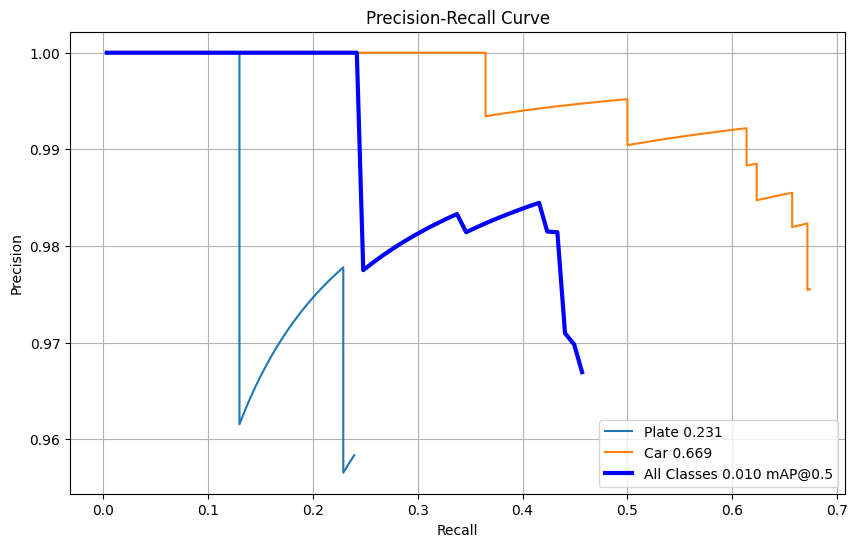

In [29]:
plot_PR_Curve(platePR, carPR)


In [30]:
def plot_Curve(df1,df2,y_Label):
  df1_sorted = df1.sort_values(by='Confidence')
  df2_sorted = df2.sort_values(by='Confidence')

  plt.figure(figsize=(10, 6))

  # Generate the interpolation points
  short_points = np.linspace(0, 1, len(df1_sorted))
  long_points = np.linspace(0, 1, len(df2_sorted))

  # Interpolating df2 to the length of df1
  interpolator = interp1d(long_points, df2_sorted[y_Label], kind='linear', fill_value="extrapolate")
  interpolated_long_data = interpolator(short_points)

  # Interpolating Confidence values similarly
  interpolator_conf = interp1d(long_points, df2_sorted['Confidence'], kind='linear', fill_value="extrapolate")
  interpolated_long_conf = interpolator_conf(short_points)

  # Compute the average data
  average_data = (df1_sorted[y_Label].values + interpolated_long_data) / 2
  average_conf = (df1_sorted['Confidence'].values + interpolated_long_conf) / 2
  idx = np.argmax(average_data)
  # Plotting
  plt.plot(df1_sorted['Confidence'], df1_sorted[y_Label], label='Plate')
  plt.plot(df2_sorted['Confidence'], df2_sorted[y_Label], label='Car')
  plt.plot(average_conf, average_data, label=f'All Classes Max Score = {average_data[idx]:.3f} at {average_conf[idx]:.3f}', color='blue', linewidth=3)

  plt.xlabel('Confidence')
  plt.ylabel(y_Label)
  plt.title(f'{y_Label} Curve')
  plt.grid(True)
  plt.legend()
  plt.savefig(f'{y_Label}.png')
  plt.show()



In [31]:
class_instances = test_ann_df['category_id'].value_counts()
car_count = class_instances.iloc[0]
plate_count = class_instances.iloc[1]
car_count, plate_count

(125, 78)

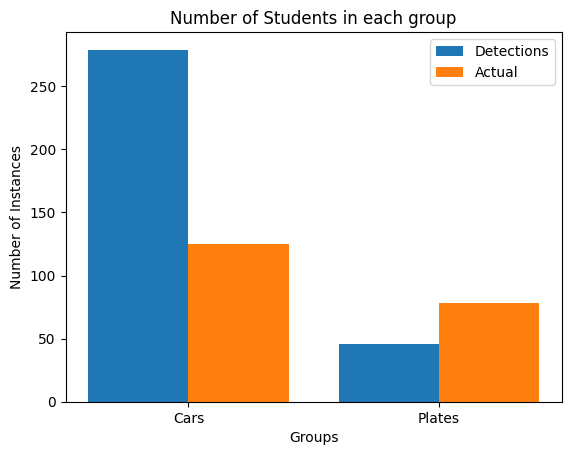

In [32]:

import numpy as np
import matplotlib.pyplot as plt

X = ['Cars','Plates']
detected = [len(carPR[carPR['TP'] == 1]), len(platePR[platePR['TP'] == 1])]
labeled = [car_count, plate_count]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, detected, 0.4, label = 'Detections')
plt.bar(X_axis + 0.2, labeled, 0.4, label = 'Actual')

plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Number of Instances")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

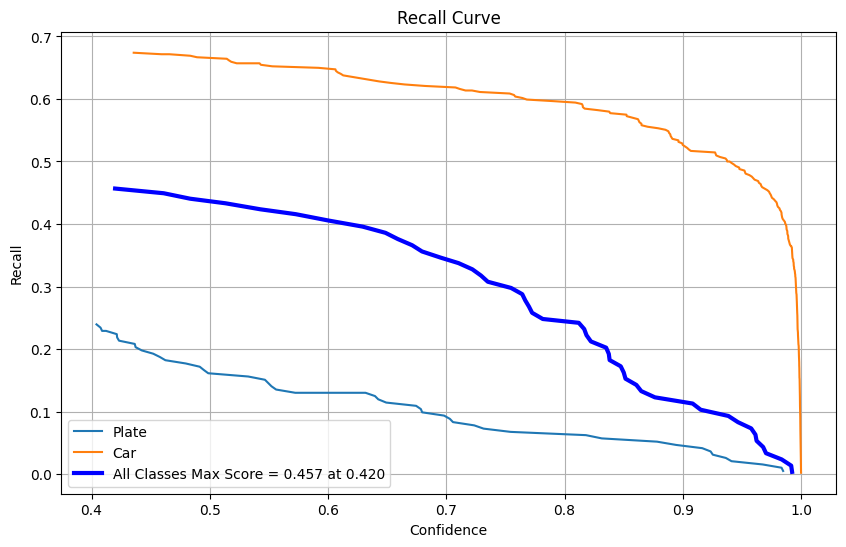

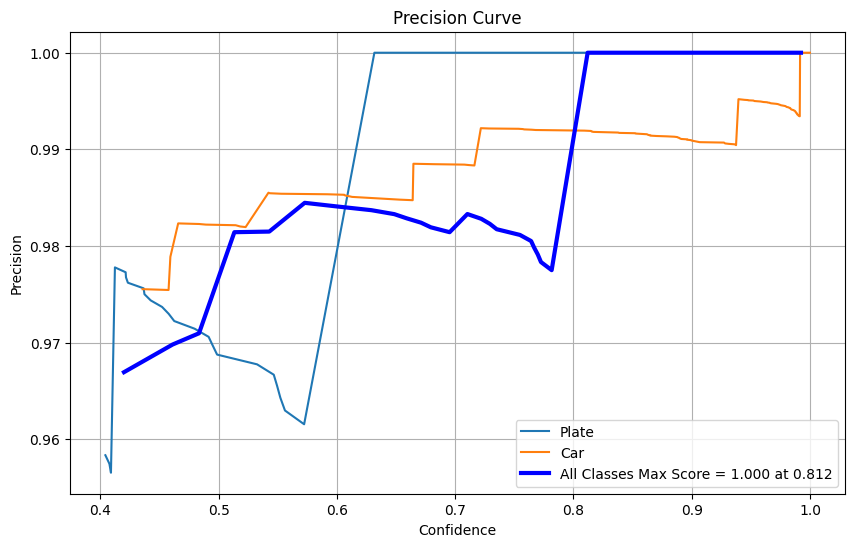

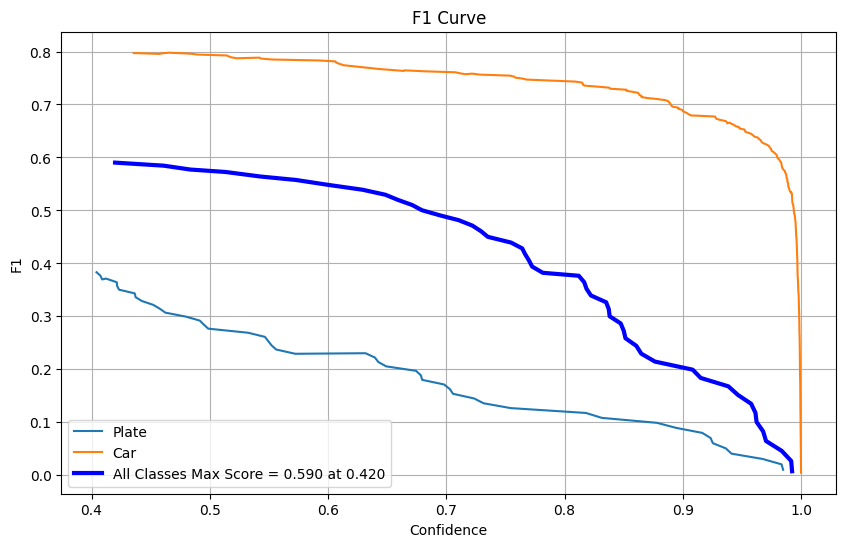

In [33]:
plot_Curve(platePR, carPR, 'Recall')
plot_Curve(platePR, carPR, 'Precision')
plot_Curve(platePR, carPR, 'F1')

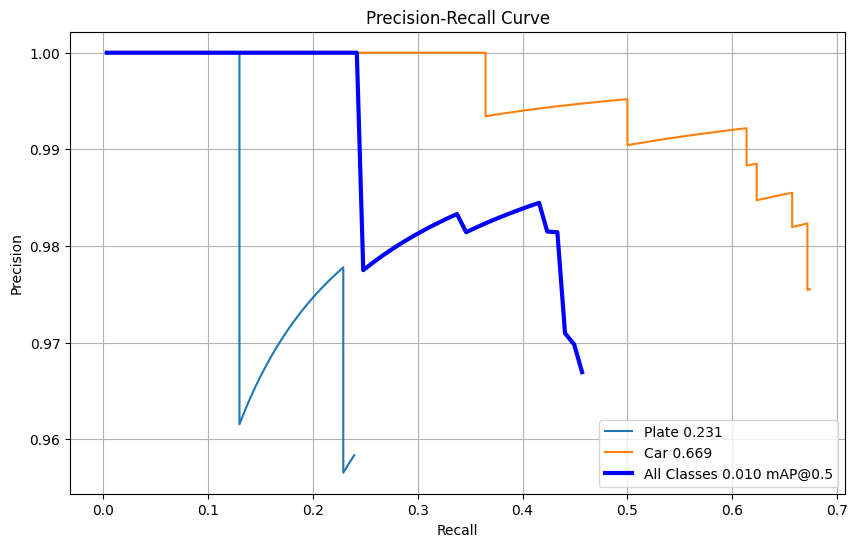

In [34]:
plot_PR_Curve(platePR, carPR)

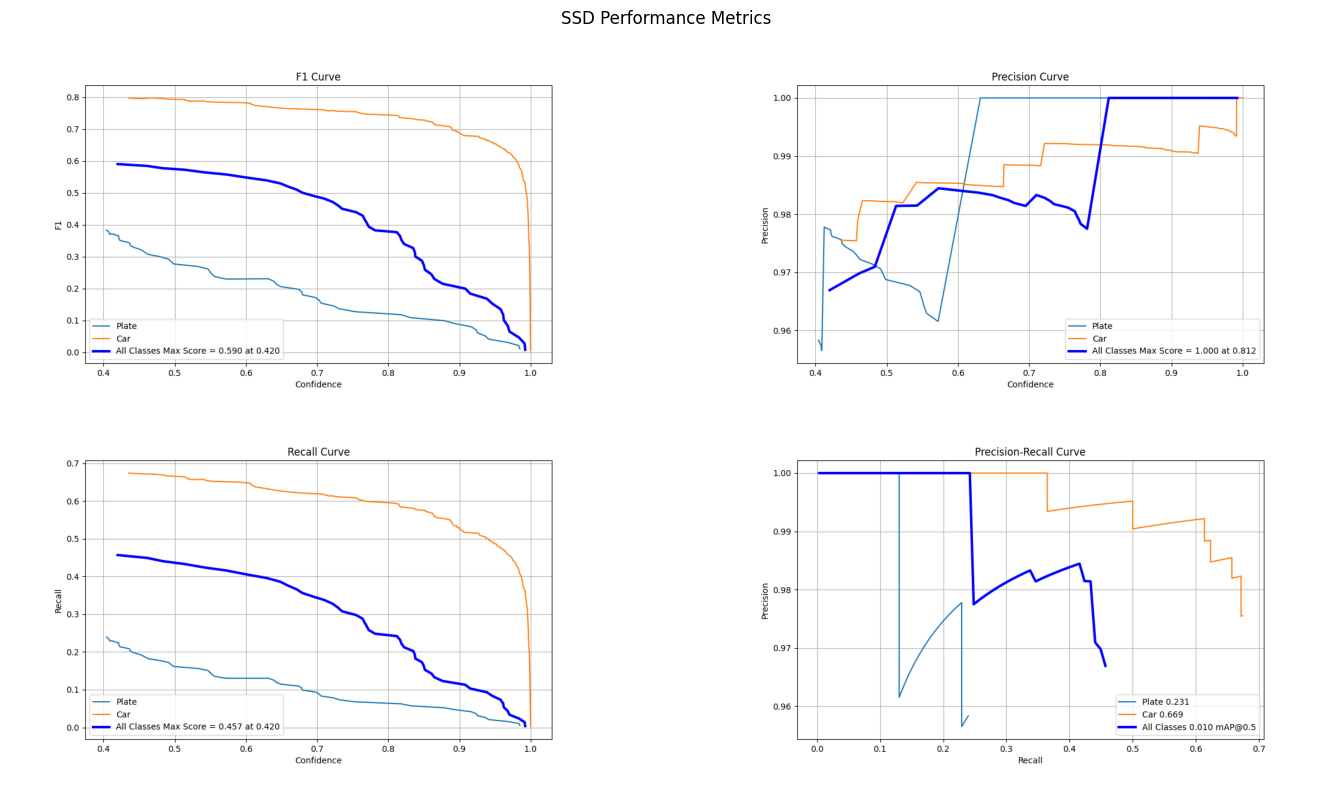

In [35]:
import matplotlib.image as mpimg

# File names of the images
image_files = ['/content/F1.png',
               '/content/Precision.png',
               '/content/Recall.png',
                '/content/PR_Curve.png']

# Load images
images = [mpimg.imread(image_file) for image_file in image_files]

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plot each image
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Hide axes
fig.suptitle("SSD Performance Metrics")
# Adjust layout
plt.tight_layout()
plt.show()

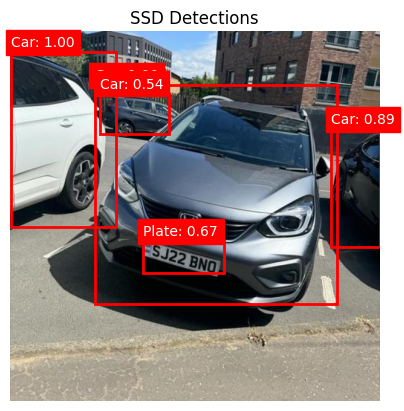

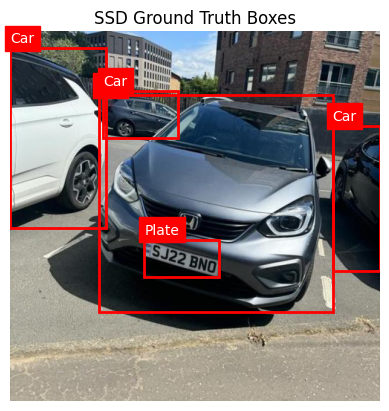

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from torchvision.ops import nms

def plot_predictions(image, boxes, scores, classes, class_names, img_id, score_threshold=0.4):
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0).cpu())
    refined_boxes = nms(boxes, scores, 0.4)
    picked_boxes = boxes[refined_boxes]

    # Plot each bounding box
    for box, score, cls in zip(picked_boxes, scores, classes):
        if score >= score_threshold:
            x1, y1, x2, y2 = box
            # Create a rectangle patch
            rect = patches.Rectangle(
                (x1.item(), y1.item()), x2.item()-x1.item(), y2.item()-y1.item(), linewidth=2, edgecolor='r', facecolor='none'
            )
            print
            # Add the patch to the Axes
            ax.add_patch(rect)

            # Label with class name and score
            class_name = class_names[str(cls.item())]
            label = f'{class_name}: {score:.2f}'
            ax.text(x1, y1 - 10, label, color='white', fontsize=10, backgroundcolor='red')

            # Or label with the class number and the score
            # label = f'{str(cls.item())}:{score:.2f}'
            # ax.text(x1, y1 - 10, label, color='white', fontsize=10, backgroundcolor='red')


    plt.axis('off')
    plt.title('SSD Detections')
    plt.savefig(f'{img_id}_detection.png')
    plt.show()

# Function to plot image with bounding boxes
def plot_image_with_annotations(img, targets, img_id):
    # Get the file path of the image
    fig, ax = plt.subplots(1)
    ax.imshow(img.permute(1,2,0).cpu())
    for box, cls in zip(targets['boxes'], targets['labels']):
      x1, y1, x2, y2 = box
      # Create a rectangle patch
      rect = patches.Rectangle(
          (x1.item(), y1.item()), x2.item()-x1.item(), y2.item()-y1.item(), linewidth=2, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)

      # Label with class name and score
      class_name = CLASS_NAMES[str(cls.item())]
      label = f'{class_name}'
      ax.text(x1, y1 - 10, label, color='white', fontsize=10, backgroundcolor='red')
    plt.axis('off')
    plt.title('SSD Ground Truth Boxes')
    plt.savefig(f'{img_id}_labels.png')

    plt.show()
# outputs[44]
img_id = 12
# print(outputs[img_id]['labels'], outputs[img_id]['scores'])
plot_predictions(imgs[img_id], outputs[img_id]['boxes'], outputs[img_id]['scores'], outputs[img_id]['labels'], CLASS_NAMES, img_id, 0.5)
plot_image_with_annotations(imgs[img_id], targets[img_id], img_id)


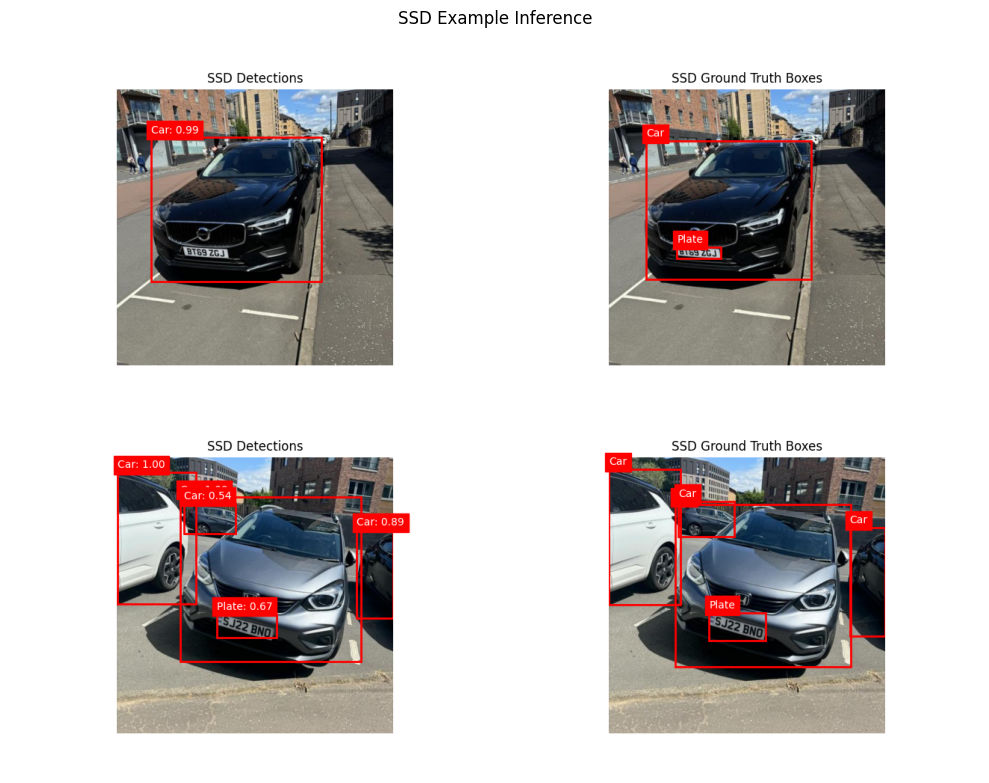

In [59]:
import matplotlib.image as mpimg

# File names of the images
image_files = ['/content/21_detection.png',
               '/content/21_labels.png',
               '/content/12_detection.png',
                '/content/12_labels.png']

# Load images
images = [mpimg.imread(image_file) for image_file in image_files]

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot each image
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Hide axes
fig.suptitle("SSD Example Inference")
# Adjust layout
plt.tight_layout()
plt.show()

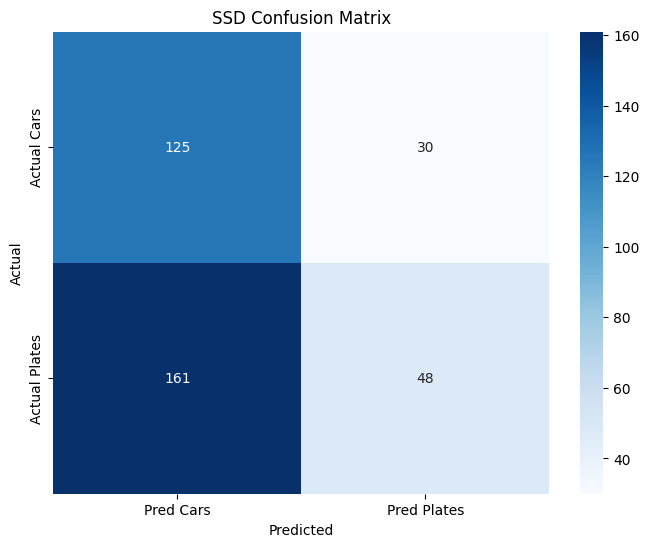

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix values
class1_actual = car_count
class2_actual = plate_count
class1_predicted = len(car_df)
class2_predicted = len(plate_df)

# Construct the confusion matrix
confusion_matrix = np.array([[class1_actual, abs(class2_actual - class2_predicted)],
                             [abs(class1_actual - class1_predicted), class2_predicted]])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Cars', 'Pred Plates'], yticklabels=['Actual Cars', 'Actual Plates'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SSD Confusion Matrix')
plt.show()

#Saving Data for model comparison
##Inference Times

In [38]:
inf_times = pd.DataFrame(inferencing_times, columns=['SSD_Model'])
inf_times.head()

,SSD_Model
0,0.136627
1,0.015350
2,0.014381
3,0.016199
4,0.014746


In [39]:

inf_times.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/inference_times.csv', index=False)

##Data Spread

In [40]:
data = {
    'Actual Cars': [car_count],
    'Actual Plates': [plate_count],
    'Predicted Cars': [len(car_df)],
    'Predicted Plates': [len(plate_df)]}
data_spread_df = pd.DataFrame(data)
data_spread_df.head()
data_spread_df.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Data_Spread.csv', index=False)

##Data frames for curves

In [41]:
carPR.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Car_Class_APRF.csv', index=False)
platePR.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Plate_Class_APRF.csv', index=False)